<center><h1>Patel_Datt_HW7</h1></center>

## Datt Patel, Late days used: 1

Name: Datt Patel
<br>
Github Username: dattpatel99 
<br>
USC ID: 2149812400

## 1. Multi-class and Multi-Label Classification Using Support Vector Machines

Import packages

In [62]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, LinearSVC
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans
from scipy.spatial import distance as distance_cal
from sklearn.metrics import silhouette_samples, silhouette_score
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning

import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

### (a) Download the Anuran Calls (MFCCs) Data Set

In [63]:
df = pd.read_csv('../data/Frogs_MFCCs.csv')

In [64]:
df.head()

,MFCCs_ 1,MFCCs_ 2,MFCCs_ 3,MFCCs_ 4,MFCCs_ 5,MFCCs_ 6,MFCCs_ 7,MFCCs_ 8,MFCCs_ 9,MFCCs_10,...,MFCCs_17,MFCCs_18,MFCCs_19,MFCCs_20,MFCCs_21,MFCCs_22,Family,Genus,Species,RecordID
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038,Leptodactylidae,Adenomera,AdenomeraAndre,1
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056,Leptodactylidae,Adenomera,AdenomeraAndre,1
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162,Leptodactylidae,Adenomera,AdenomeraAndre,1
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954,Leptodactylidae,Adenomera,AdenomeraAndre,1
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244,Leptodactylidae,Adenomera,AdenomeraAndre,1


In [65]:
df.dtypes

MFCCs_ 1    float64
MFCCs_ 2    float64
MFCCs_ 3    float64
MFCCs_ 4    float64
MFCCs_ 5    float64
MFCCs_ 6    float64
MFCCs_ 7    float64
MFCCs_ 8    float64
MFCCs_ 9    float64
MFCCs_10    float64
MFCCs_11    float64
MFCCs_12    float64
MFCCs_13    float64
MFCCs_14    float64
MFCCs_15    float64
MFCCs_16    float64
MFCCs_17    float64
MFCCs_18    float64
MFCCs_19    float64
MFCCs_20    float64
MFCCs_21    float64
MFCCs_22    float64
Family       object
Genus        object
Species      object
RecordID      int64
dtype: object

In [66]:
df.Family = df.Family.astype('category')
df.Genus = df.Genus.astype('category')
df.Species = df.Species.astype('category')
df.RecordID = df.RecordID.astype('category')

# Get Train and Test Data

In [67]:
X, y = df.iloc[:,:-4], df.iloc[:,-4:]

In [68]:
train_x, test_x, train_y, test_y = train_test_split(X,y,train_size=0.7,shuffle=True)
scaler = StandardScaler()
std_train_x = scaler.fit_transform(train_x)
std_test_x = scaler.fit_transform(test_x)

In [69]:
label_columns = train_y.columns
label_data = {}
for label in label_columns[:-1]:
    label_data[label] = {'train': train_y[label], 'test': test_y[label]}

### (b) Train a classifier for each label

#### (i) Research

References:
1. https://mmuratarat.github.io/2020-01-25/multilabel_classification_metrics
2. https://www.linkedin.com/pulse/hamming-score-multi-label-classification-chandra-sharat/
3. https://scikit-learn.org/stable/modules/generated/sklearn.metrics.hamming_loss.html

Exact Match: Only consider a fully matching label to be correct, if the label is matching only partially do not count as correct.

Hamming Loss: Average number of times a classes label is incorrectly predictred.

#### (ii) Train a SVM for each of the labels

In [70]:
def getExactMatch(true_y, ls_yPreds):
    ratio = 0
    for y, y_hat in zip(true_y.values, ls_yPreds.values):
        # Check if each column has matching value if so 
        # increment the ratio by 1 for each row that matches
        if (sum(y == y_hat) == true_y.shape[1]):
            ratio += 1
    ratio /= true_y.shape[0] # divide by number of rows
    return ratio

def getHammingLoss(y_true, y_pred):
    num_miss = 0
    # Check for each value the number of missed values
    # sum the total 
    for y, y_hat in zip(y_true.values, y_pred.values):
        missed = (y!=y_hat)
        num_miss += np.sum(missed)
    hamming = num_miss / (y_true.shape[0]*y_true.shape[1])
    return hamming

# y is the dataframe of 4 different predictors
# labeled_data is the dictionary I have created above
def getPredictedResults(test_x, y, labeled_datas, grids):
    predicted_labels = {}
    for key in list(labeled_datas.keys()):
        cur_model = grids[key]
        y_hat = cur_model.predict(test_x)
        predicted_labels[key] = y_hat
    return predicted_labels

def getErrors(y ,predicted_lables):
    exact_match = getExactMatch(y, predicted_lables)
    hamming = getHammingLoss(y, predicted_lables)
    return {'Exact': exact_match, 'Hamming Loss': hamming, 'Hamming Score': 1-hamming}

In [71]:
# Create the tests of train and test for each of the labels
tuning_params = {'C':np.logspace(-2,6,9),
                 'gamma':np.arange(0.1,2.1,0.1)}
splitter = StratifiedKFold(10, random_state=99, shuffle=True)

grid_params_svm = {'param_grid': tuning_params,
                   'cv':splitter}

In [72]:
def performGridSearch(model, tune_params, train_x, train_y, detail):
    grid = GridSearchCV(model, **tune_params, verbose=1, n_jobs=-1)
    grid.fit(train_x, train_y)
    
    means = grid.cv_results_['mean_test_score']
    params = grid.cv_results_['params']
    
    print('Grid Search Results:{}'.format(detail))
    
    for mean, param in zip(means, params):
        print('Mean Test Score: {}, Params: {}'.format(mean, param))
    
    print('Best Parameter setting: {}'.format(grid.best_params_))
    
    return grid

In [91]:
grid_search_results = {}
detail = '{} SVM without Standarization'
for label in label_columns[:-1]:
    print('Label: {}'.format(label))
    grid_search_results[label] = performGridSearch(SVC(), grid_params_svm, train_x, label_data[label]['train'], detail.format(label))

Label: Family
Fitting 10 folds for each of 180 candidates, totalling 1800 fits
Grid Search Results:Family SVM without Standarization
Mean Test Score: 0.6151712739436398, Params: {'C': 0.01, 'gamma': 0.1}
Mean Test Score: 0.713861276783742, Params: {'C': 0.01, 'gamma': 0.2}
Mean Test Score: 0.8318138786329641, Params: {'C': 0.01, 'gamma': 0.30000000000000004}
Mean Test Score: 0.8349932153113068, Params: {'C': 0.01, 'gamma': 0.4}
Mean Test Score: 0.8328079144182523, Params: {'C': 0.01, 'gamma': 0.5}
Mean Test Score: 0.8347944081542492, Params: {'C': 0.01, 'gamma': 0.6}
Mean Test Score: 0.8411487424658398, Params: {'C': 0.01, 'gamma': 0.7000000000000001}
Mean Test Score: 0.8486963141784216, Params: {'C': 0.01, 'gamma': 0.8}
Mean Test Score: 0.8550502540313675, Params: {'C': 0.01, 'gamma': 0.9}
Mean Test Score: 0.8598176812143015, Params: {'C': 0.01, 'gamma': 1.0}
Mean Test Score: 0.8620010098141311, Params: {'C': 0.01, 'gamma': 1.1}
Mean Test Score: 0.8643831455710185, Params: {'C': 0.01,

### SMV Exact Match, Hamming Loss, Hamming Score

In [92]:
y_hats_nonStandard = getPredictedResults(test_x, test_y, label_data, grid_search_results)
y_preds_nonStandard = pd.DataFrame(y_hats_nonStandard)

In [93]:
results_svm = getErrors(test_y.iloc[:,:-1], y_preds_nonStandard)
pd.DataFrame(results_svm, index=['Results'])

,Exact,Hamming Loss,Hamming Score
Results,0.988884,0.008337,0.991663


#### (iii) Repeat 1(b)ii with L1-penalized SVMs

In [76]:
tuning_params_l1 = {'C': np.logspace(-3,6,10)}
grid_search_params_l1 = {'param_grid': tuning_params_l1,'cv': splitter}

In [77]:
def performGridSearchL1(model, tune_params, train_x, train_y, detail):
    grid = GridSearchCV(model, **tune_params, verbose=1, n_jobs=-1)
    grid.fit(train_x, train_y)
    means = grid.cv_results_['mean_test_score']
    params = grid.cv_results_['params']    
    print('Grid Search Results:{}'.format(detail))
    for mean, param in zip(means, params):
        print('Mean Test Score: {}, Params: {}'.format(mean, param))    
    print('Best Parameter setting: {}'.format(grid.best_params_))
    return grid

In [78]:
l1_grid_search_results = {}
detail = '{} L1 SVC'
for label in label_columns[:-1]:
    print('Label: {}'.format(label))
    l1_grid_search_results[label] = performGridSearchL1(LinearSVC(penalty='l1', dual=False), grid_search_params_l1, std_train_x, label_data[label]['train'], detail.format(label))

Label: Family
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Grid Search Results:Family L1 SVC
Mean Test Score: 0.8512756792577866, Params: {'C': 0.001}
Mean Test Score: 0.9295141847328725, Params: {'C': 0.01}
Mean Test Score: 0.9370589952349396, Params: {'C': 0.1}
Mean Test Score: 0.938051847644293, Params: {'C': 1.0}
Mean Test Score: 0.9382502603427059, Params: {'C': 10.0}
Mean Test Score: 0.9382502603427059, Params: {'C': 100.0}
Mean Test Score: 0.9382502603427059, Params: {'C': 1000.0}
Mean Test Score: 0.9382502603427059, Params: {'C': 10000.0}
Mean Test Score: 0.9382502603427059, Params: {'C': 100000.0}
Mean Test Score: 0.9382502603427059, Params: {'C': 1000000.0}
Best Parameter setting: {'C': 10.0}
Label: Genus
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Grid Search Results:Genus L1 SVC
Mean Test Score: 0.8202913471551643, Params: {'C': 0.001}
Mean Test Score: 0.9120337498816624, Params: {'C': 0.01}
Mean Test Score: 0.942018129319322, Params: {'

### L1 SVM Exact Match, Hamming Loss, Hamming Score 

In [79]:
y_hats_l1 = getPredictedResults(std_test_x, test_y, label_data, l1_grid_search_results)
y_preds_l1 = pd.DataFrame(y_hats_l1)

In [80]:
results_l1 = getErrors(test_y.iloc[:,:-1], y_preds_l1)
pd.DataFrame(results_l1, index=['Results'])

,Exact,Hamming Loss,Hamming Score
Results,0.917554,0.052493,0.947507


#### (iv) Repeat 1(b)iii by using SMOTE or any other method for imbalance

In [81]:
tuning_params_smote = {'classifier__C': np.logspace(-3,6,10)}

grid_search_params_smote = {'param_grid': tuning_params_smote,
                        'cv': splitter}

In [82]:
def performGridSearchSMOTE(model, tune_params, train_x, train_y, detail):
    grid = GridSearchCV(model, **tune_params, verbose=1, n_jobs=-1)
    grid.fit(train_x, train_y)
    means = grid.cv_results_['mean_test_score']
    params = grid.cv_results_['params']    
    print('Grid Search Results:{}'.format(detail))
    for mean, param in zip(means, params):
        print('Mean Test Score: {}, Params: {}'.format(mean, param))    
    print('Best Parameter setting: {}'.format(grid.best_params_))
    return grid

In [83]:
pipe = Pipeline([('smote', SMOTE()),('classifier', LinearSVC(penalty='l1', dual=False))])

smote_grid_search_results = {}
detail = '{} SMOTE L1 SVC'
for label in label_columns[:-1]:
    print('Label: {}'.format(label))
    smote_grid_search_results[label] = performGridSearchSMOTE(pipe, grid_search_params_smote, std_train_x, label_data[label]['train'], detail.format(label))

Label: Family
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Grid Search Results:Family SMOTE L1 SVC
Mean Test Score: 0.8189115308151094, Params: {'classifier__C': 0.001}
Mean Test Score: 0.8945615986619962, Params: {'classifier__C': 0.01}
Mean Test Score: 0.9156095174981855, Params: {'classifier__C': 0.1}
Mean Test Score: 0.9167999936886616, Params: {'classifier__C': 1.0}
Mean Test Score: 0.9183892675691882, Params: {'classifier__C': 10.0}
Mean Test Score: 0.9171956357095521, Params: {'classifier__C': 100.0}
Mean Test Score: 0.9189856890403609, Params: {'classifier__C': 1000.0}
Mean Test Score: 0.9175960112341823, Params: {'classifier__C': 10000.0}
Mean Test Score: 0.9179920477137177, Params: {'classifier__C': 100000.0}
Mean Test Score: 0.9179908643377829, Params: {'classifier__C': 1000000.0}
Best Parameter setting: {'classifier__C': 1000.0}
Label: Genus
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Grid Search Results:Genus SMOTE L1 SVC
Mean Test Scor

### SMOTE, L1 Exact Match, Hamming Loss, Hamming Score

In [88]:
y_hats_smote = getPredictedResults(std_test_x, test_y, label_data, smote_grid_search_results)
y_preds_smote = pd.DataFrame(y_hats_smote)

In [89]:
results_smote = getErrors(test_y.iloc[:,:-1], y_preds_smote)
pd.DataFrame(results_smote, index=['Results'])

,Exact,Hamming Loss,Hamming Score
Results,0.865679,0.069013,0.930987


## Overall Results for SVM

In [94]:
pd.DataFrame([results_svm, results_l1, results_smote], index=['SVM','L1', 'SMOTE L1'])

,Exact,Hamming Loss,Hamming Score
SVM,0.988884,0.008337,0.991663
L1,0.917554,0.052493,0.947507
SMOTE L1,0.865679,0.069013,0.930987


Using the results in the table above we can see that the best model would be a simple SVM using raw data.

## 2. K-Means Clustering on a Multi-Class and Multi-Label Data Set

### (a) Use k-means clustering

In [64]:
dataset = df
X, y = dataset.iloc[:,:-4], dataset.iloc[:,-4:-1]

In [65]:
def getHammingInformation(y, y_hat):
    missed = []
    for c,c1 in zip(y,y_hat):
        missed.append(len(y_hat.loc[:, c]) * distance_cal.hamming(y.loc[:,c], y_hat.loc[:, c]))
    total_missed = sum(missed)
    hamming_distance = total_missed / (y.shape[0])
    hamming_loss = total_missed / (y.shape[0]*y.shape[1])
    hamming_score = 1-hamming_loss
    return {'Hamming Distance': hamming_distance, 'Hamming Loss':hamming_loss,'Hamming Score':hamming_score}

def getMajorityDF(k, y, y_hat):
    print('Majority Label:')  
    rows = len(y_hat)
    prediction = pd.DataFrame(y_hat, columns=['ClusterResult'])
    prediction['Family'] = [None for i in range(rows)]
    prediction['Genus'] = [None for i in range(rows)]
    prediction['Species'] = [None for i in range(rows)]
    for i in range(k):
        idx = y.index[prediction['ClusterResult'] == i]
        f = y.loc[idx,'Family'].value_counts().index[0]
        g = y.loc[idx,'Genus'].value_counts().index[0]
        s = y.loc[idx,'Species'].value_counts().index[0]
        prediction.loc[idx,'Family'] = f
        prediction.loc[idx,'Genus'] = g
        prediction.loc[idx,'Species'] = s
        print('Cluster: {}, Family: {}, Genus: {}, Species: {}'.format(i,f,g,s))
    return prediction

# One run of the K clusters and pick best K
def runKMeans(clusters, X, run):
    best_cluster = 2
    max_silhouette = -1
    for c in range(2,clusters+1):
        cluster_model = KMeans(n_clusters=c,random_state=run)
        cluster_labels = cluster_model.fit_predict(X)

        silhouette_avg = silhouette_score(X, cluster_labels)
        if silhouette_avg > max_silhouette:
            best_cluster = c
            max_silhouette = silhouette_avg
    print('Best K: {}, Silhouette Score: {}'.format(best_cluster, max_silhouette))
    return best_cluster

In [72]:
def monteCarlo(repeats, X):
    result_predictions = {}
    best_k = []
    for i in range(repeats):
        print('Attempt {}'.format(i))
        k = runKMeans(50, X, i)
        cluster_model = KMeans(k, random_state=i)
        cluster_yhat = cluster_model.fit_predict(X)
        result_predictions['Attempt{}'.format(i)] = cluster_yhat
        best_k.append(k)
    return result_predictions, best_k

def wrapperMajorityLabels(y, k_predictions, best_k):
    keys = list(k_predictions.keys())
    labels = {}
    for idx in range(len(keys)):
        print('Attempt Number: {}'.format(idx+1))
        cur_prediction = k_predictions[keys[idx]]
        labels[idx] = getMajorityDF(best_k[idx], y, cur_prediction)
    return labels

def wrapperHammingInformation(y, k_predictions):
    keys = list(k_predictions.keys())
    results_hamming = {}
    for key in keys:
        cur_y_hat = k_predictions[key][['Family', 'Genus','Species']]
        hamming = getHammingInformation(y, cur_y_hat)
        results_hamming[key] = hamming
    return results_hamming

In [67]:
predictions, best_k = monteCarlo(50, X)

Attempt 0
Best K: 4, Silhouette Score: 0.3788646212055977
Attempt 1
Best K: 4, Silhouette Score: 0.3787509343305295
Attempt 2
Best K: 4, Silhouette Score: 0.38523395202479643
Attempt 3
Best K: 4, Silhouette Score: 0.3787509343305295
Attempt 4
Best K: 4, Silhouette Score: 0.3787509343305295
Attempt 5
Best K: 4, Silhouette Score: 0.3787509343305295
Attempt 6
Best K: 4, Silhouette Score: 0.3787509343305295
Attempt 7
Best K: 4, Silhouette Score: 0.3787509343305295
Attempt 8
Best K: 4, Silhouette Score: 0.3787509343305295
Attempt 9
Best K: 4, Silhouette Score: 0.3787509343305295
Attempt 10
Best K: 4, Silhouette Score: 0.3787509343305295
Attempt 11
Best K: 4, Silhouette Score: 0.3787509343305295
Attempt 12
Best K: 4, Silhouette Score: 0.3787509343305295
Attempt 13
Best K: 4, Silhouette Score: 0.37863353074850936
Attempt 14
Best K: 4, Silhouette Score: 0.3787509343305295
Attempt 15
Best K: 4, Silhouette Score: 0.37863353074850936
Attempt 16
Best K: 4, Silhouette Score: 0.3787509343305295
Atte

### (b) Determine which family is the majority

In [73]:
list_majority_labels = wrapperMajorityLabels(y, predictions, best_k)

Attempt Number: 1
Majority Label:
Cluster: 0, Family: Leptodactylidae, Genus: Adenomera, Species: AdenomeraHylaedactylus
Cluster: 1, Family: Dendrobatidae, Genus: Ameerega, Species: Ameeregatrivittata
Cluster: 2, Family: Hylidae, Genus: Hypsiboas, Species: HypsiboasCinerascens
Cluster: 3, Family: Hylidae, Genus: Hypsiboas, Species: HypsiboasCordobae
Attempt Number: 2
Majority Label:
Cluster: 0, Family: Hylidae, Genus: Hypsiboas, Species: HypsiboasCinerascens
Cluster: 1, Family: Dendrobatidae, Genus: Ameerega, Species: Ameeregatrivittata
Cluster: 2, Family: Leptodactylidae, Genus: Adenomera, Species: AdenomeraHylaedactylus
Cluster: 3, Family: Hylidae, Genus: Hypsiboas, Species: HypsiboasCordobae
Attempt Number: 3
Majority Label:
Cluster: 0, Family: Hylidae, Genus: Hypsiboas, Species: HypsiboasCordobae
Cluster: 1, Family: Leptodactylidae, Genus: Adenomera, Species: AdenomeraHylaedactylus
Cluster: 2, Family: Hylidae, Genus: Hypsiboas, Species: HypsiboasCordobae
Cluster: 3, Family: Leptoda

### (c) Calculate the average Hamming distance, Hamming score, and Hamming loss

In [69]:
hamming_map = wrapperHammingInformation(y, list_majority_labels)
hamming_table = pd.DataFrame(hamming_map).T
hamming_table.index.name = 'Attempts'

In [70]:
hamming_table

,Hamming Distance,Hamming Loss,Hamming Score
Attempts,,,
0,0.665323,0.221774,0.778226
1,0.667269,0.222423,0.777577
2,0.735789,0.245263,0.754737
3,0.667269,0.222423,0.777577
4,0.667269,0.222423,0.777577
5,0.667269,0.222423,0.777577
6,0.667269,0.222423,0.777577
7,0.667269,0.222423,0.777577
8,0.667269,0.222423,0.777577


### Mean and SD of Hamming Distances 

In [71]:
mean_distance = np.mean(hamming_table.loc[:,'Hamming Distance'])
std_distance = np.std(hamming_table.loc[:, 'Hamming Distance'])
pd.DataFrame({'Mean': mean_distance, 'STD': std_distance}, index=['Hamming Distance']).T

,Hamming Distance
Mean,0.671169
STD,0.031020


## 3. ISLR 12.6.2

## (a)

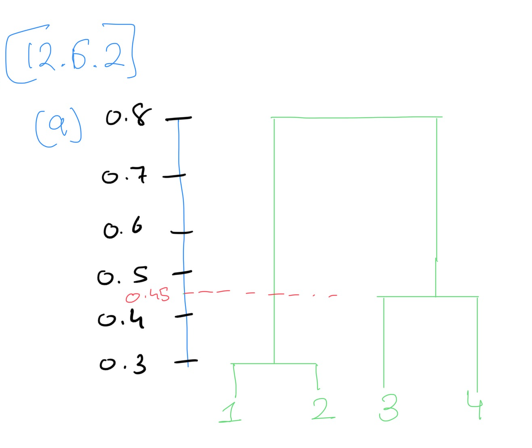

## (b)

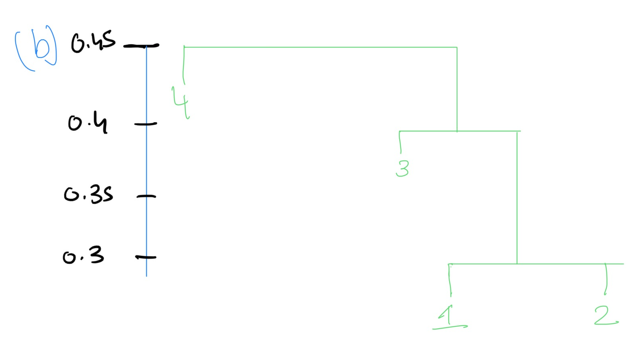

## (c)

The two clusters are (1,2) and (3,4)

## (d)

The two clusters are (1,2,3) and (4)

## (e)

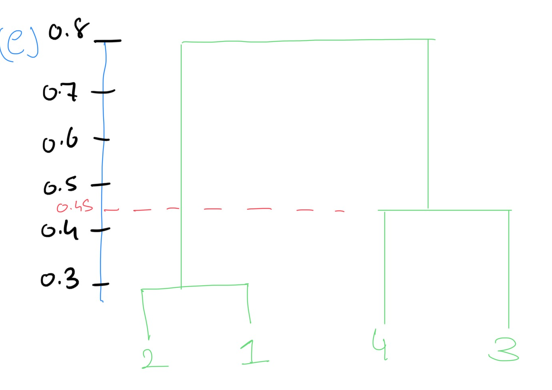